# ACT Demo: Verification with VNNLib

Complete verification workflow using ACT framework with VNNLib benchmarks:
1. **Model Loading**: Load VNNLib benchmark and synthesize models
2. **Verification**: IntervalTF (forward bounds) + DualTF (certified bounds)
3. **Analysis**: Spurious counterexample inference

In [1]:
# Setup and imports
import sys, os 
import io
from contextlib import redirect_stdout

f = io.StringIO()
# with redirect_stdout(f):
#     from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator
#     from act.front_end.model_synthesis import synthesize_models_from_specs
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, act_root) if act_root not in sys.path else None

import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path
from collections import Counter

# Force reload modules
import importlib
modules_to_reload = [
    'act.front_end.model_synthesis',
    'act.front_end.vnnlib_loader.create_specs',
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator
from act.front_end.model_synthesis import synthesize_models_from_specs
from act.pipeline.verification.torch2act import TorchToACT
from act.back_end.dual_tf import DualTF, compute_forward_bounds

# CIFAR-100 class names
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print("Setup complete")

[ACT] Auto-detecting project root: /data1/guanqin/newACT/ACT
[WARN] Gurobi license not found at: /data1/guanqin/newACT/ACT/modules/gurobi/gurobi.lic
[INFO] Please ensure gurobi.lic is placed in: /data1/guanqin/newACT/ACT/modules/gurobi
Setup complete


## Step 1: Load VNNLib Benchmark and Synthesize Models

In [2]:
print("="*80)
print("LOADING CIFAR-100 VNNLIB BENCHMARK")
print("="*80)

# Load VNNLib instances
creator = VNNLibSpecCreator(config_name="vnnlib_default")
spec_results = creator.create_specs_for_data_model_pairs(
    categories=["cifar100_2024"],
    max_instances=3,
    validate_shapes=True
)
print(f"Loaded {len(spec_results)} instances\n")

# Synthesize wrapped models
print("Synthesizing wrapped models...")
wrapped_models, reports = synthesize_models_from_specs(spec_results)
print(f"Synthesized {len(wrapped_models)} wrapped models\n")

# Extract instance info for all models
instance_info = []
wrapped_models_list = list(wrapped_models.values())
combo_ids = list(wrapped_models.keys())

for idx, (combo_id, wrapped_model) in enumerate(wrapped_models.items()):
    input_layer = wrapped_model[0]
    labeled_input = input_layer.labeled_input
    input_spec_layer = wrapped_model[1]
    input_spec = input_spec_layer.spec
    epsilon = float((input_spec.ub - input_spec.lb).max())
    
    instance_info.append({
        'index': idx,
        'combo_id': combo_id,
        'input_tensor': labeled_input.tensor,
        'true_label': labeled_input.label,
        'epsilon': epsilon,
        'input_spec': input_spec,
        'labeled_input': labeled_input
    })
    print(f"Instance {idx+1}: {CIFAR100_CLASSES[labeled_input.label]} (label={labeled_input.label}), eps={epsilon:.6f}")

print(f"\nReady for fuzzing and verification")

INFO:act.front_end.vnnlib_loader.create_specs:Creating VNNLIB specs: categories=['cifar100_2024'], max_instances=3
INFO:act.front_end.vnnlib_loader.create_specs:Processing 3 VNNLIB instances
INFO:act.front_end.vnnlib_loader.create_specs:Loading instance: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_116_sidx_8002_eps_0.0039
INFO:act.front_end.vnnlib_loader.data_model_loader:Loading VNNLIB instance: cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:[1/3] Converting ONNX model to PyTorch...
INFO:act.front_end.vnnlib_loader.onnx_converter:Loading ONNX model from /data1/guanqin/newACT/ACT/data/vnnlib/cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.onnx_converter:Converting ONNX to PyTorch
INFO:act.front_end.vnnlib_loader.onnx_converter:Converted model to device=cpu, dtype=torch.float64
INFO:act.front_end.vnnlib_loader.onnx_converter:Successfully converted ONNX model: CIFAR100_resnet_mediu

LOADING CIFAR-100 VNNLIB BENCHMARK


INFO:act.front_end.vnnlib_loader.create_specs:Loading instance: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_4071_sidx_6244_eps_0.0039
INFO:act.front_end.vnnlib_loader.data_model_loader:Loading VNNLIB instance: cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:[1/3] Converting ONNX model to PyTorch...
INFO:act.front_end.vnnlib_loader.onnx_converter:Loading ONNX model from /data1/guanqin/newACT/ACT/data/vnnlib/cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.onnx_converter:Converting ONNX to PyTorch
INFO:act.front_end.vnnlib_loader.onnx_converter:Converted model to device=cpu, dtype=torch.float64
INFO:act.front_end.vnnlib_loader.onnx_converter:Successfully converted ONNX model: CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:  ✓ Model converted successfully
INFO:act.front_end.vnnlib_loader.data_model_loader:[2/3] Extracting input shape...
INFO:act.front_e

Loaded 3 instances

Synthesizing wrapped models...

🧬 Synthesizing models from 3 spec result(s)...
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_116_sidx_8002_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_4071_sidx_6244_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_1862_sidx_1111_eps_0.0039: Created 1 wrapped model(s)

🎉 Synthesized 3 wrapped models from specs!
Synthesized 3 wrapped models

Instance 1: tank (label=85), eps=0.030590
Instance 2: shrew (label=74), eps=0.030590
Instance 3: table (label=84), eps=0.030590

Ready for fuzzing and verification


## Step 2: Convert to ACT Net for Verification

In [3]:
print("="*80)
print("CONVERTING TO ACT NET")
print("="*80)

# Use first instance for verification demo
demo_idx = 0
wrapped_model = wrapped_models_list[demo_idx]
info = instance_info[demo_idx]
input_tensor = info['input_tensor']
true_label = info['true_label']
input_spec = info['input_spec']
epsilon = info['epsilon']

print(f"Demo instance: {CIFAR100_CLASSES[true_label]} (label={true_label})")

# Convert to ACT Net
converter = TorchToACT(wrapped_model)
act_net = converter.run()

print(f"ACT layers: {len(act_net.layers)}")
print(f"Variables: {converter.next_var}")

# Show network structure summary
print(f"\nNetwork structure (first 5 and last 3 layers):")
for i, layer in enumerate(act_net.layers[:5]):
    print(f"  {i:2d}. {layer.kind:15s} | Out vars: {len(layer.out_vars):6d}")
print("  ...")
for i, layer in enumerate(act_net.layers[-3:], len(act_net.layers)-3):
    print(f"  {i:2d}. {layer.kind:15s} | Out vars: {len(layer.out_vars):6d}")

CONVERTING TO ACT NET
Demo instance: tank (label=85)
ACT layers: 73
Variables: 246700

Network structure (first 5 and last 3 layers):
   0. INPUT           | Out vars:   3072
   1. INPUT_SPEC      | Out vars:   3072
   2. CONV2D          | Out vars:  14400
   3. SCALE           | Out vars:  14400
   4. BIAS            | Out vars:  14400
  ...
  70. RELU            | Out vars:    100
  71. DENSE           | Out vars:    100
  72. ASSERT          | Out vars:    100


## Step 3: IntervalTF - Layer-by-Layer Bounds Propagation

INTERVAL BOUNDS PROPAGATION (Layer-by-Layer)
Input bounds: lb=[-1.8824, 1.9682], ub=[-1.8531, 1.9966]

Running forward interval propagation...
Computed bounds for 73 layers

Layer  Kind                Vars  Width(mean)   Width(max)
-------------------------------------------------------
0      INPUT               3072       0.0294       0.0306
1      INPUT_SPEC          3072       0.0294       0.0306
2      CONV2D             14400       0.1273       0.3711
3      SCALE              14400       0.0833       0.2984
4      BIAS               14400       0.0833       0.2984
5      RELU               14400       0.0833       0.2984
6      CONV2D              8192       1.1273       6.1086
7      SCALE               8192       0.1810       0.8373
8      BIAS                8192       0.1810       0.8373
9      RELU                8192       0.1810       0.8373
...
68     FLATTEN              512       0.0000       0.0000
69     DENSE                100       0.0000       0.0000
70     RELU 

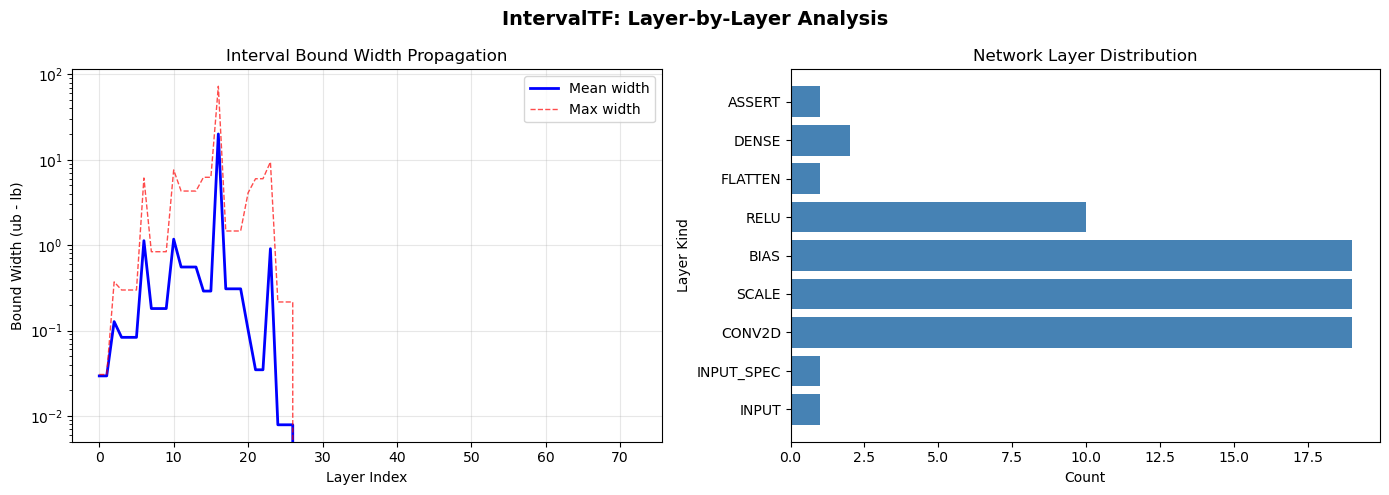


Key Observations:
  Input bound width (mean): 0.029446
  Output bound width (mean): 0.000000
  Bound expansion ratio: 0.00x

Output layer bounds:
  Shape: torch.Size([100])
  lb range: [-3.0816, -0.2668]
  ub range: [-3.0816, -0.2668]


In [4]:
print("="*80)
print("INTERVAL BOUNDS PROPAGATION (Layer-by-Layer)")
print("="*80)

# Create input bounds from epsilon
if input_tensor.dim() == 4:
    input_flat = input_tensor.squeeze(0).flatten()
else:
    input_flat = input_tensor.flatten()

# Use bounds from input_spec
input_lb = input_spec.lb.flatten()
input_ub = input_spec.ub.flatten()

print(f"Input bounds: lb=[{input_lb.min():.4f}, {input_lb.max():.4f}], ub=[{input_ub.min():.4f}, {input_ub.max():.4f}]")

# Compute forward bounds
print("\nRunning forward interval propagation...")
bounds_dict = compute_forward_bounds(act_net, input_lb, input_ub)
print(f"Computed bounds for {len(bounds_dict)} layers")

# Collect layer statistics
layer_stats = []
for layer in act_net.layers:
    bounds = bounds_dict.get(layer.id)
    if bounds is not None:
        lb, ub = bounds.lb, bounds.ub
        width = (ub - lb)
        layer_stats.append({
            'id': layer.id,
            'kind': layer.kind,
            'num_vars': len(lb.flatten()),
            'width_mean': width.mean().item(),
            'width_max': width.max().item(),
            'lb_range': f"[{lb.min().item():.3f}, {lb.max().item():.3f}]",
            'ub_range': f"[{ub.min().item():.3f}, {ub.max().item():.3f}]",
        })

# Print table
print(f"\n{'Layer':<6} {'Kind':<15} {'Vars':>8} {'Width(mean)':>12} {'Width(max)':>12}")
print("-"*55)
for s in layer_stats[:10]:
    print(f"{s['id']:<6} {s['kind']:<15} {s['num_vars']:>8} {s['width_mean']:>12.4f} {s['width_max']:>12.4f}")
if len(layer_stats) > 15:
    print("...")
for s in layer_stats[-5:]:
    print(f"{s['id']:<6} {s['kind']:<15} {s['num_vars']:>8} {s['width_mean']:>12.4f} {s['width_max']:>12.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bound width evolution
layer_indices = range(len(layer_stats))
mean_widths = [s['width_mean'] for s in layer_stats]
max_widths = [s['width_max'] for s in layer_stats]

axes[0].plot(layer_indices, mean_widths, 'b-', label='Mean width', linewidth=2)
axes[0].plot(layer_indices, max_widths, 'r--', label='Max width', linewidth=1, alpha=0.7)
axes[0].set_xlabel('Layer Index')
axes[0].set_ylabel('Bound Width (ub - lb)')
axes[0].set_title('Interval Bound Width Propagation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Layer kind distribution
kind_counts = Counter([s['kind'] for s in layer_stats])
kinds = list(kind_counts.keys())
counts = list(kind_counts.values())
axes[1].barh(kinds, counts, color='steelblue')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Layer Kind')
axes[1].set_title('Network Layer Distribution')

plt.suptitle('IntervalTF: Layer-by-Layer Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key observations
print(f"\nKey Observations:")
print(f"  Input bound width (mean): {layer_stats[0]['width_mean']:.6f}")
print(f"  Output bound width (mean): {layer_stats[-1]['width_mean']:.6f}")
expansion_ratio = layer_stats[-1]['width_mean'] / (layer_stats[0]['width_mean'] + 1e-10)
print(f"  Bound expansion ratio: {expansion_ratio:.2f}x")

# Store output bounds for DualTF
output_layer = act_net.layers[-2]  # Before ASSERT
output_bounds = bounds_dict.get(output_layer.id)
if output_bounds:
    print(f"\nOutput layer bounds:")
    print(f"  Shape: {output_bounds.lb.shape}")
    print(f"  lb range: [{output_bounds.lb.min():.4f}, {output_bounds.lb.max():.4f}]")
    print(f"  ub range: [{output_bounds.ub.min():.4f}, {output_bounds.ub.max():.4f}]")

## Step 4: DualTF - Robust Classification Bound

In [5]:
print("="*80)
print("DUAL TF VERIFICATION")
print("="*80)

dual_tf = DualTF()
num_classes = 100

# Compute robust bound
min_margin, is_certified = dual_tf.compute_robust_bound(act_net, bounds_dict, true_label, num_classes)

print(f"\nRobust verification result:")
print(f"  True label: {true_label} ({CIFAR100_CLASSES[true_label]})")
print(f"  Min margin: {min_margin.item():.6f}")
print(f"  Status: {'CERTIFIED' if is_certified else 'NOT CERTIFIED'}")

# Compute detailed margins for top adversarial classes
print(f"\nDetailed margins for top adversarial classes:")

# Get model prediction to find top classes
if input_tensor.dim() == 3:
    input_batch = input_tensor.unsqueeze(0)
else:
    input_batch = input_tensor

with torch.no_grad():
    orig_output = wrapped_model(input_batch)
    if isinstance(orig_output, dict):
        orig_output = orig_output['output']
    orig_pred = orig_output.argmax(dim=1).item()
    orig_conf = torch.softmax(orig_output[0], dim=0)[orig_pred].item()
    top10_classes = torch.topk(orig_output[0], k=10).indices.tolist()

print(f"\nOriginal prediction: {CIFAR100_CLASSES[orig_pred]} (conf: {orig_conf:.3f})")
print(f"Top 10 classes: {top10_classes}")

# Compute margins
margins = []
for target_class in top10_classes:
    if target_class == true_label:
        continue
    
    c = torch.zeros(num_classes, dtype=output_bounds.lb.dtype, device=output_bounds.lb.device)
    c[true_label] = 1.0
    c[target_class] = -1.0
    
    margin = dual_tf.compute_bound(act_net, bounds_dict, c)
    margins.append((target_class, margin.item()))
    
    status = "OK" if margin.item() > 0 else "VULNERABLE"
    print(f"  Class {target_class:3d} ({CIFAR100_CLASSES[target_class]:20s}): margin = {margin.item():8.4f} [{status}]")

# Find most vulnerable class
margins.sort(key=lambda x: x[1])
weakest_class, weakest_margin = margins[0]
print(f"\nMost vulnerable adversarial class: {weakest_class} ({CIFAR100_CLASSES[weakest_class]})")
print(f"Margin: {weakest_margin:.6f}")

DUAL TF VERIFICATION

Robust verification result:
  True label: 85 (tank)
  Min margin: -2.224983
  Status: NOT CERTIFIED

Detailed margins for top adversarial classes:

Original prediction: tank (conf: 0.415)
Top 10 classes: [85, 89, 51, 37, 15, 58, 91, 17, 13, 26]
  Class  89 (tractor             ): margin =   1.0659 [OK]
  Class  51 (mushroom            ): margin =  -1.5691 [VULNERABLE]
  Class  37 (house               ): margin =  -0.8568 [VULNERABLE]
  Class  15 (camel               ): margin =  -0.6875 [VULNERABLE]
  Class  58 (pickup_truck        ): margin =   0.5949 [OK]
  Class  91 (trout               ): margin =  -0.6166 [VULNERABLE]
  Class  17 (castle              ): margin =   1.6071 [OK]
  Class  13 (bus                 ): margin =   1.4352 [OK]
  Class  26 (crab                ): margin =  -0.5105 [VULNERABLE]

Most vulnerable adversarial class: 51 (mushroom)
Margin: -1.569103


## Step 5: Spurious Counterexample (SCE) Analysis

SPURIOUS COUNTEREXAMPLES (SCE) ANALYSIS FOR TOP 5 ADVERSARIAL CLASSES


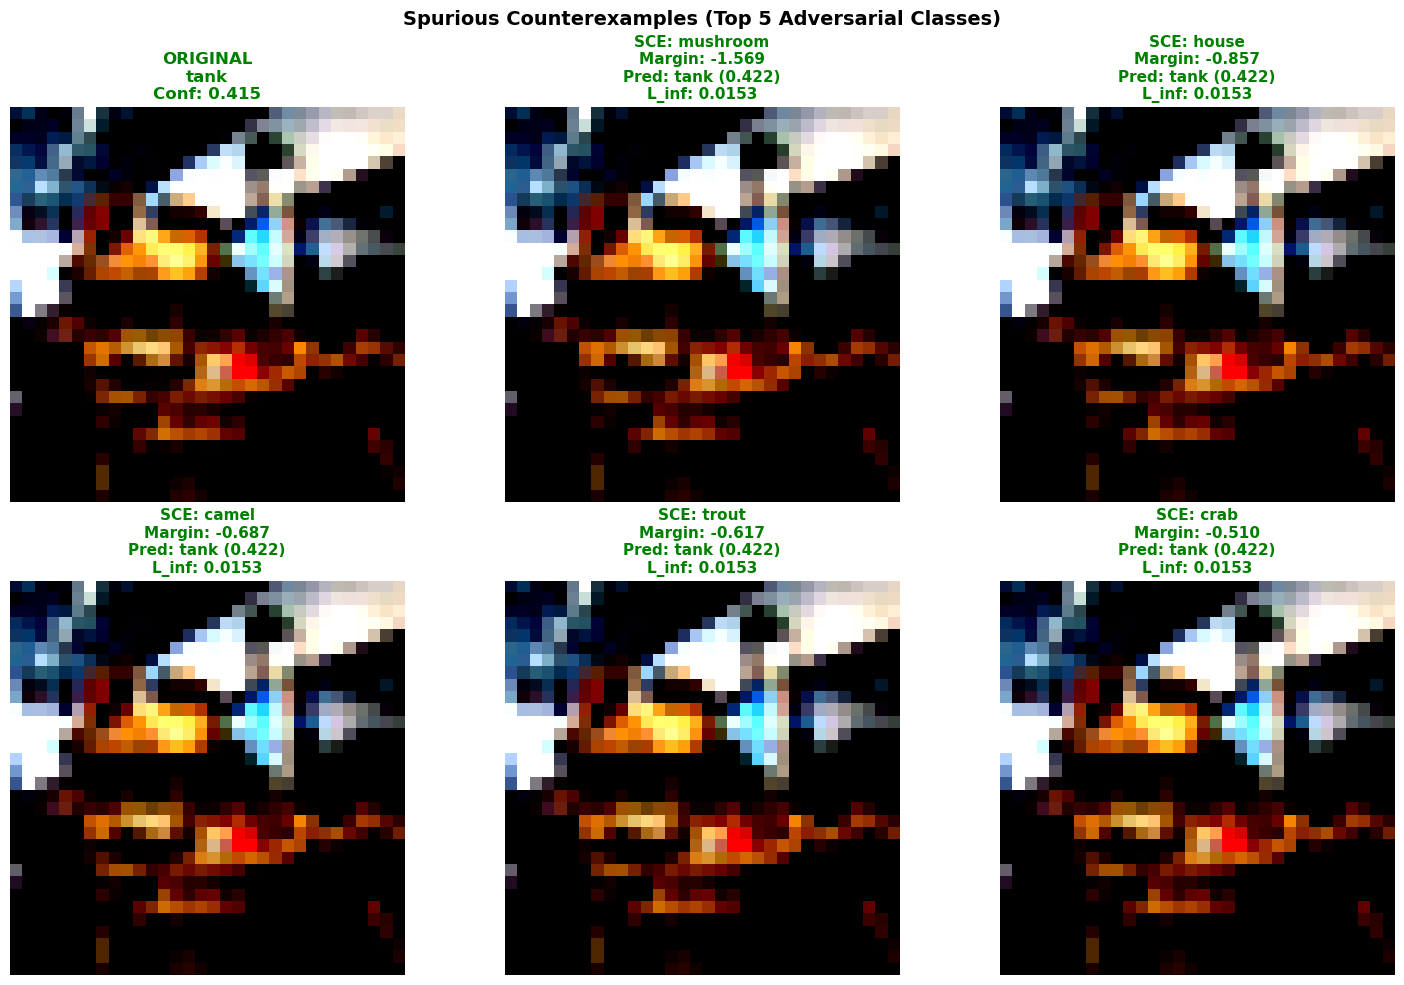


AdvClass            ClassName     Margin  SCE_pred             PredName     Conf    L_inf  Within_eps
      51 mushroom                -1.5691        85 tank                   0.4221   0.0153        True
      37 house                   -0.8568        85 tank                   0.4221   0.0153        True
      15 camel                   -0.6875        85 tank                   0.4221   0.0153        True
      91 trout                   -0.6166        85 tank                   0.4221   0.0153        True
      26 crab                    -0.5105        85 tank                   0.4221   0.0153        True

Most vulnerable (min margin) in Top 5: 51 (mushroom)
Margin: -1.569103

RESULT: SCE maintains correct classification
  This is a SPURIOUS counterexample (greedy boundary selection)
  Real adversarial may exist but requires more sophisticated search


In [6]:
print("="*80)
print("SPURIOUS COUNTEREXAMPLES (SCE) ANALYSIS FOR TOP 5 ADVERSARIAL CLASSES")
print("="*80)

# Select the top 5 adversarial classes by margin (lowest 5 non-true_label in top10)
sce_infos = []
adv_class_candidates = []

# 1. Gather (adv_class, margin) for all top10 classes (excluding true_label)
for adv_class in top10_classes:
    if adv_class == true_label:
        continue
    c = torch.zeros(num_classes, dtype=output_bounds.lb.dtype, device=output_bounds.lb.device)
    c[true_label] = 1.0
    c[adv_class] = -1.0
    margin = dual_tf.compute_bound(act_net, bounds_dict, c)
    if isinstance(margin, torch.Tensor):
        margin = margin.item()
    adv_class_candidates.append((adv_class, margin))

# 2. Sort by margin, pick top 5 most vulnerable (lowest margins)
topk = 5
adv_class_sorted = sorted(adv_class_candidates, key=lambda x: x[1])[:topk]

# 3. For each of the top 5, generate SCE info
for adv_class, margin in adv_class_sorted:
    c = torch.zeros(num_classes, dtype=output_bounds.lb.dtype, device=output_bounds.lb.device)
    c[true_label] = 1.0
    c[adv_class] = -1.0
    margin_val, sce_raw = dual_tf.compute_bound(act_net, bounds_dict, c, return_sce=True)
    if isinstance(margin_val, torch.Tensor):
        margin_val = margin_val.item()
    expected_size = 3 * 32 * 32  # image size for CIFAR

    # Recover SCE image
    if sce_raw.numel() != expected_size:
        input_layer = act_net.layers[1]
        input_bounds = bounds_dict.get(input_layer.id)
        if input_bounds is not None:
            sce_image = input_bounds.lb.clone().reshape(1, 3, 32, 32)
        else:
            sce_image = input_tensor.clone()
    else:
        sce_image = sce_raw.reshape(1, 3, 32, 32)

    # Inference
    pytorch_model = wrapped_model[2]
    pytorch_model.eval()
    with torch.no_grad():
        sce_output = pytorch_model(sce_image)
        sce_pred = sce_output.argmax(dim=1).item()
        sce_probs = torch.softmax(sce_output[0], dim=0)
        sce_conf = sce_probs[sce_pred].item()
        sce_target_conf = sce_probs[adv_class].item()

    # Perturbation w.r.t. original input
    if input_tensor.dim() == 4:
        orig_tensor = input_tensor.squeeze(0)
    else:
        orig_tensor = input_tensor
    diff = sce_image.squeeze() - orig_tensor.reshape(3, 32, 32).to(sce_image.device)
    l_inf = diff.abs().max().item()
    
    sce_infos.append({
        "adv_class": adv_class,
        "adv_class_name": CIFAR100_CLASSES[adv_class],
        "margin": margin_val,
        "sce_pred": sce_pred,
        "sce_pred_name": CIFAR100_CLASSES[sce_pred],
        "sce_conf": sce_conf,
        "sce_target_conf": sce_target_conf,
        "l_inf": l_inf,
        "sce_image": sce_image
    })

# 4. Visualization: 3x2 grid, first is ORIGINAL and five SCEs
import math
nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))

# Plot original image in [0,0]
if input_tensor.dim() == 4:
    orig_tensor = input_tensor.squeeze(0)
else:
    orig_tensor = input_tensor
orig_img = orig_tensor.reshape(3, 32, 32).permute(1, 2, 0)
orig_img_np = np.clip(orig_img.cpu().numpy(), 0, 1)
axes[0,0].imshow(orig_img_np, interpolation='nearest')
axes[0,0].set_title(f'ORIGINAL\n{CIFAR100_CLASSES[true_label]}\nConf: {orig_conf:.3f}', 
                    fontsize=12, color='green', fontweight='bold')
axes[0,0].axis('off')

for idx, info in enumerate(sce_infos):
    pos = idx + 1
    row = pos // ncol
    col = pos % ncol
    ax = axes[row, col]
    sce_img = info['sce_image'].squeeze().permute(1, 2, 0)
    sce_img_np = np.clip(sce_img.cpu().numpy(), 0, 1)
    ax.imshow(sce_img_np, interpolation='nearest')
    color = 'red' if info['sce_pred'] != true_label else 'green'
    ax.set_title(
        f"SCE: {info['adv_class_name']}\n"
        f"Margin: {info['margin']:.3f}\n"
        f"Pred: {info['sce_pred_name']} ({info['sce_conf']:.3f})\n"
        f"L_inf: {info['l_inf']:.4f}",
        fontsize=11, color=color, fontweight='bold'
    )
    ax.axis('off')

# Hide empty axes if any
for i in range(len(sce_infos) + 1, nrow*ncol):
    row = i // ncol
    col = i % ncol
    axes[row, col].axis('off')

plt.suptitle('Spurious Counterexamples (Top 5 Adversarial Classes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Table summary
print(f"\n{'AdvClass':>8s} {'ClassName':>20s} {'Margin':>10s} {'SCE_pred':>9s} {'PredName':>20s} {'Conf':>8s} {'L_inf':>8s} {'Within_eps':>11s}")
for info in sce_infos:
    within_eps = info["l_inf"] <= epsilon
    print(f"{info['adv_class']:8d} {info['adv_class_name']:20s} {info['margin']:10.4f} {info['sce_pred']:9d} {info['sce_pred_name']:20s} {info['sce_conf']:8.4f} {info['l_inf']:8.4f} {str(within_eps):>11s}")

# Also, summary for the one with lowest margin among the selected
min_info = min(sce_infos, key=lambda x: x["margin"])
print("\n" + "="*62)
print(f"Most vulnerable (min margin) in Top 5: {min_info['adv_class']} ({min_info['adv_class_name']})")
print(f"Margin: {min_info['margin']:.6f}")
print("="*62)

if min_info['sce_pred'] != true_label:
    if min_info['sce_pred'] == min_info['adv_class']:
        print(f"\nRESULT: SCE causes misclassification to TARGET class!")
    else:
        print(f"\nRESULT: SCE causes misclassification to different class: {min_info['sce_pred_name']}")
else:
    print("\nRESULT: SCE maintains correct classification")
    print("  This is a SPURIOUS counterexample (greedy boundary selection)")
    print("  Real adversarial may exist but requires more sophisticated search")

## Step 6: Results Summary

In [7]:
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

print(f"\n[Model Information]")
print(f"  Benchmark: cifar100_2024")
print(f"  Instances tested: {len(instance_info)}")
print(f"  Demo instance: {CIFAR100_CLASSES[true_label]} (label={true_label})")
print(f"  Epsilon: {epsilon:.6f}")

print(f"\n[DualTF Verification]")
print(f"  Min margin: {min_margin.item():.6f}")
print(f"  Certified: {is_certified}")
print(f"  Most vulnerable class: {weakest_class} ({CIFAR100_CLASSES[weakest_class]})")

print(f"\n[SCE Analysis]")
print(f"  SCE prediction: {CIFAR100_CLASSES[sce_pred]}")
print(f"  Misclassification: {sce_pred != true_label}")
print(f"  Perturbation L_inf: {l_inf:.6f}")

print(f"\n[Conclusion]")
if is_certified:
    print(f"  Model is CERTIFIED ROBUST for this instance")
else:
    print(f"  Model is NOT CERTIFIED ROBUST")
    if sce_pred != true_label:
        print(f"  SCE analysis suggests potential vulnerability to class {CIFAR100_CLASSES[sce_pred]}")
    else:
        print(f"  Further analysis recommended")

print("\n" + "="*80)
print("DEMO COMPLETE")
print("="*80)



COMPREHENSIVE RESULTS SUMMARY

[Model Information]
  Benchmark: cifar100_2024
  Instances tested: 3
  Demo instance: tank (label=85)
  Epsilon: 0.030590

[DualTF Verification]
  Min margin: -2.224983
  Certified: False
  Most vulnerable class: 51 (mushroom)

[SCE Analysis]
  SCE prediction: tank
  Misclassification: False
  Perturbation L_inf: 0.015295

[Conclusion]
  Model is NOT CERTIFIED ROBUST
  Further analysis recommended

DEMO COMPLETE
